In [ ]:
#CLEANED

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle

In [2]:
all_gens = np.arange(0,9899)
seasons = np.tile(np.repeat([0, 1], 300), 100)
season_len = 300
n_seasons = int(np.floor(9899/season_len))
chunked_gens = np.array([all_gens[i*season_len:(i+1)*season_len] for i in range(n_seasons)])

s1 = chunked_gens[0::2]
new_col = (s1[:, 0] - 1).reshape(-1, 1)
s1 = np.hstack((new_col, s1))[:,:-1]

s2 = chunked_gens[1::2]
new_col = (s2[:, 0] - 1).reshape(-1, 1)
s2 = np.hstack((new_col, s2))[:,:-1]

In [3]:
#PERCENT KIDS BETTER THAN PARENTS
#At season change, so gen 299 the kids have input 1, not input 0
#in this code below, the kids are compared to their parents with the same initial condition (input 1)
#in the season 0 list the last gens are 298, 898, 1498, etc and the first gens are 0, 599, 1199
# also, yes, surviving parent is counted in the == but that is the case every generation so it won't influence slope 

rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150, 102]


all_props1=[]
all_props2=[]
pdic=[]
for rule in rules:
    with open(os.path.expanduser(f'~/CA_GRN_results/kid_fit_results/kid_fits_{rule}.p'), 'rb') as f:
        kid_fits = pickle.load(f)

    ave_nums_higher1=[]
    ave_nums_higher2=[]
    for rep in range(15):
        s1 = chunked_gens[0::2]
        new_col = (s1[:, 0] - 1).reshape(-1, 1) #adding the last gen of previous season as kids of that gen used this season input
        gens1 = np.hstack((new_col, s1))[:,:-1].flatten() #removing the last gen of the season as kids of that gen used next season input
        gens1 = gens1[1:] #fixing the fact that the first season (ever) is not kids of a previous gen
        curr = 0
        num_higher = np.sum(kid_fits[rep,gens1,curr,:,:] > kid_fits[rep,gens1,curr,:,0][..., np.newaxis], axis = -1) #first in list is parent
        num_higher = num_higher.mean(axis=1) #average across parents
        ave_nums_higher1.append(num_higher)

        s2 = chunked_gens[1::2]
        new_col = (s2[:, 0] - 1).reshape(-1, 1) #same reason as above
        gens2 = np.hstack((new_col, s2))[:,:-1].flatten()
        curr = 1
        num_higher = np.sum(kid_fits[rep,gens2,curr,:,:] > kid_fits[rep,gens2,curr,:,0][..., np.newaxis], axis = -1) #first in list is parent
        num_higher = num_higher.mean(axis=1) #average across parents
        ave_nums_higher2.append(num_higher)
    ave_nums_higher1 = np.array(ave_nums_higher1)
    ave_nums_higher2 = np.array(ave_nums_higher2)

    ave_nums_higher_mean1 = np.mean(ave_nums_higher1, axis=0) #average across replicates
    ave_nums_higher_mean2 = np.mean(ave_nums_higher2, axis=0) #average across replicates

    mystats=True
    if mystats:
        at_switch1_y = np.insert(ave_nums_higher1[:,299::300], 0, ave_nums_higher1[:,0], axis = 1) 
        at_switch2_y = ave_nums_higher2[:,::300] 

        for s in [at_switch1_y, at_switch2_y]:
            time = np.arange(s.shape[1])
            # Fit linear regression for each replicate to get the slope
            slopes = []
            for replicate in s:
                slope, intercept, r_value, p_value, std_err = stats.linregress(time, replicate)
                slopes.append(slope)
            slopes = np.array(slopes)
            # Now test if the average slope is significantly greater than zero
            #This is a test for the null hypothesis that the expected value (mean) of a sample of 
            # independent observations _slopes_ is equal to the given number, 0.
            t_stat, p_val = stats.ttest_1samp(slopes, 0)


            pdic.append(p_val)

    z_value = 1.96
    stderr1 = np.std(ave_nums_higher_mean1, axis=0) / np.sqrt(15)
    ci_upper = ave_nums_higher_mean1 + z_value * stderr1
    ci_lower = ave_nums_higher_mean1 - z_value * stderr1

    #fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True)
    #ax.plot(gens1,ave_nums_higher_mean1, ".")
    at_switch1_y = np.insert(ave_nums_higher_mean1[299::300], 0, ave_nums_higher_mean1[0]) 
    at_switch1_x = np.insert(gens1[299::300], 0, 0)
    all_props1.append(at_switch1_y)
    
    #ax.plot(at_switch1_x,at_switch1_y, ".", color="red") #first time this target is considered for kids 0, 599, 1199, etc
    #print(rule)
    #plt.show()

    stderr1 = np.std(ave_nums_higher_mean2, axis=0) / np.sqrt(15)
    ci_upper = ave_nums_higher_mean2 + z_value * stderr1
    ci_lower = ave_nums_higher_mean2 - z_value * stderr1
    
    #fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True)
    #ax.plot(gens2,ave_nums_higher_mean2, ".")
    at_switch2_y = ave_nums_higher_mean2[::300] 
    at_switch2_x = gens2[::300]
    all_props2.append(at_switch2_y)

    #ax.plot(at_switch2_x,at_switch2_y, ".", color="red")
    #print(rule)
    #plt.show()
    

In [4]:
from statsmodels.stats.multitest import multipletests

fdr = multipletests(np.array(pdic), method='fdr_bh')[1]
labs=list(zip(np.repeat(rules, 2), np.array([0,1]*15)))
c=0
sign = []
for f in fdr:
    if f < 0.05:
        print(labs[c])
        sign.append(labs[c][0])
    c+=1
print(sign)

(70, 1)
(54, 1)
(94, 0)
(30, 0)
(50, 1)
(150, 0)
[70, 54, 94, 30, 50, 150]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


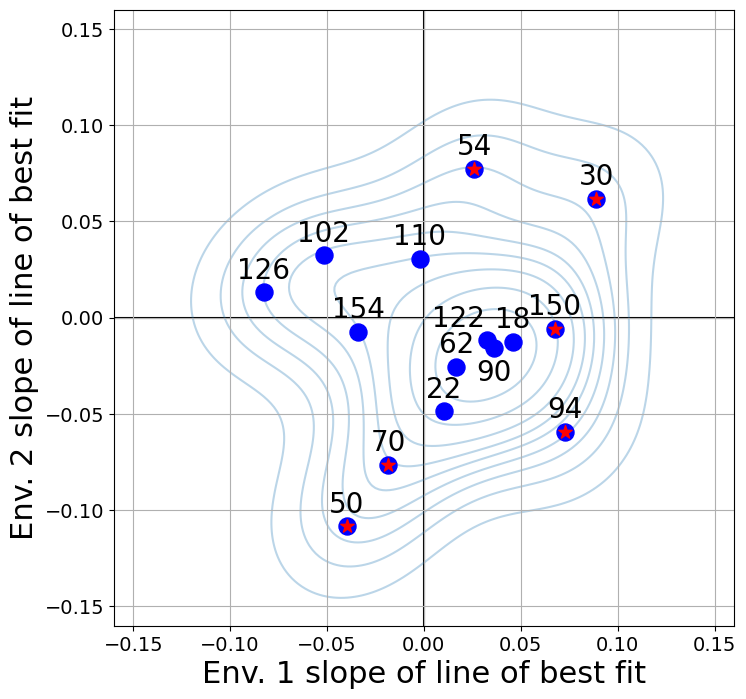

In [5]:
def get_slopes(xs):
    outs=[]
    for i in range(15):
        slope, intercept = np.polyfit(np.arange(0,len(xs[i])), xs[i], 1)
        outs.append(slope)
    return outs

nrows,ncols = 1,1
scale = 8
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*scale, nrows*scale), sharex="row", sharey="row")

x=get_slopes(all_props1)
y=get_slopes(all_props2)
plt.grid(zorder = 0)
sns.kdeplot(x = x, y = y,fill=False,thresh=0.1,zorder=1,alpha=0.3)
plt.scatter(x,y,c="blue", alpha=1,s=150,zorder=2)
for xi, yi, label in zip(x, y, rules):
    if label == 122:
        plt.text(xi-0.015, yi+0.004, label, fontsize=20, ha='center', va='bottom')
    elif label ==90:
        plt.text(xi, yi-0.02, label, fontsize=20, ha='center', va='bottom')
    else:
        plt.text(xi, yi+0.004, label, fontsize=20, ha='center', va='bottom')
    if label in sign:
        plt.scatter(xi, yi, color='red', marker='*', s=100,zorder=3)

plt.axvline(0,color="black",zorder = 0)
plt.axhline(0,color="black",zorder = 0)
plt.ylim(-0.16,0.16)
plt.xlim(-0.16,0.16)
plt.xlabel("Env. 1 slope of line of best fit", fontsize=22)
plt.ylabel("Env. 2 slope of line of best fit", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)

#plt.set_axisbelow(True)
plt.show()